<a href="https://colab.research.google.com/github/seawavve/COVIDtweetsClassification/blob/main/COVID_Classification3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 8.0MB/s 
     |████████████████████████████████| 1.6MB 7.6MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 645kB 28.4MB/s 
     |████████████████████████████████| 686kB 47.1MB/s 
     |████████████████████████████████| 215kB 51.5MB/s 
     |████████████████████████████████| 358kB 53.7MB/s 
     |████████████████████████████████| 1.2MB 54.1MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 


In [2]:
import os
import shutil
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

# 데이터 전처리

In [3]:
import pandas as pd
train = pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
test = pd.read_csv('Corona_NLP_test.csv',encoding='ISO-8859-1')
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]
train.head()


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Text(0.5, 1.0, 'Number of Sentiments in train data')

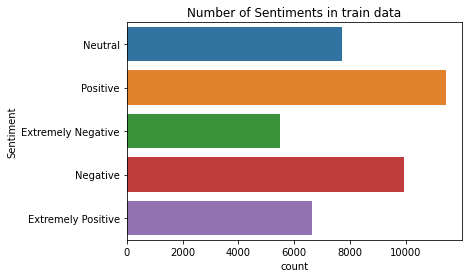

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y='Sentiment', data=train)
plt.title("Number of Sentiments in train data")

Text(0.5, 1.0, 'Number of Sentiments in test data')

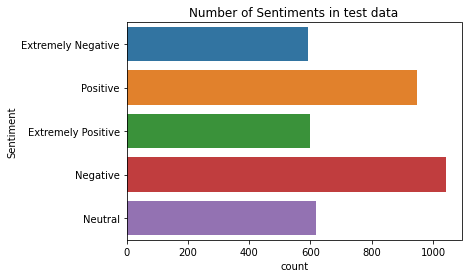

In [6]:
sns.countplot(y='Sentiment', data=test)
plt.title("Number of Sentiments in test data")

In [7]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
import string

stop_words = stopwords.words("english")
def removeUnwantedText(text):
    #remove urls
    text = re.sub(r'http\S+', " ", text)
    
    #remove mentions
    text = re.sub(r'@\w+',' ',text)
    
    #remove hastags
    text = re.sub(r'#\w+', ' ', text)
    
    #remove html tags
    text = re.sub('r<.*?>',' ', text)
    
     #remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text.lower()

train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: removeUnwantedText(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: removeUnwantedText(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
train.OriginalTweet.dropna()
train.Sentiment.dropna()
test.OriginalTweet.dropna()
test.Sentiment.dropna()

0       Extremely Negative
1                 Positive
2       Extremely Positive
3                 Negative
4                  Neutral
               ...        
3793              Positive
3794              Negative
3795               Neutral
3796    Extremely Negative
3797    Extremely Positive
Name: Sentiment, Length: 3798, dtype: object

In [9]:
from sklearn import model_selection
train_X, val_X, train_y, val_y = model_selection.train_test_split(train['OriginalTweet'],
                                                                  train['Sentiment'], 
                                                                  test_size=0.3)

test_X, test_y = test['OriginalTweet'],test['Sentiment']

In [10]:
# label_encoder = LabelEncoder()
# train['Encoded_Sentiment'] = label_encoder.fit_transform(train['Sentiment'])
# test['Encoded_Sentiment'] = label_encoder.fit_transform(test['Sentiment'])


# label_encoder = LabelEncoder()

# train['Encoded_Sentiment'] = label_encoder.fit_transform(train_y)
# test['Encoded_Sentiment'] = label_encoder.fit_transform(test['Sentiment'])
# display(train[:20])

# train['Encoded_Sentiment'] = tf.keras.utils.to_categorical(train['Encoded_Sentiment'],num_classes=5)
# test['Encoded_Sentiment'] = tf.keras.utils.to_categorical(test['Encoded_Sentiment'],num_classes=5)
# display(train[:20])
label_encoder = LabelEncoder()

vec = label_encoder.fit_transform(train_y)
train_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(val_y)
val_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(test_y)
test_y = tf.keras.utils.to_categorical(vec)


In [11]:
train_y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# 모델 

In [12]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [13]:
from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(5, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [14]:
! pip install -q tf-models-official
from official.nlp import optimization

In [15]:
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()
epochs = 3
init_lr = 3e-5
BATCH_SIZE=10
train_data_size = len(train_X)
steps_per_epoch = int(train_data_size/BATCH_SIZE)
num_train_steps = steps_per_epoch * 3
num_warmup_steps = int(0.1*num_train_steps/BATCH_SIZE)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [16]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_X,
                    y=train_y,
                    validation_data=(val_X, val_y),
                    epochs=epochs,
                    validation_steps=1,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[es])

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
2881/2881 [==============================] - 898s 306ms/step - loss: 0.9052 - categorical_accuracy: 0.6492 - val_loss: 0.6961 - val_categorical_accuracy: 0.8000
Epoch 2/3
2881/2881 [==============================] - 884s 307ms/step - loss: 0.5739 - categorical_accuracy: 0.8047 - val_loss: 0.6326 - val_categorical_accuracy: 0.8000
Epoch 3/3
2881/2881 [==============================] - 884s 307ms/step - loss: 0.4277 - categorical_accuracy: 0.8646 - val_loss: 0.7762 - val_categorical_accuracy: 0.8000


In [18]:
loss, acc = classifier_model.evaluate(x=test_X, y=test_y)
print("test loss: ", loss, ", test acc: ", 100*acc, "%")


119/119 [==============================] - 39s 323ms/step - loss: 0.8025 - categorical_accuracy: 0.7662
test loss:  0.8024818301200867 , test acc:  76.61927342414856 %


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


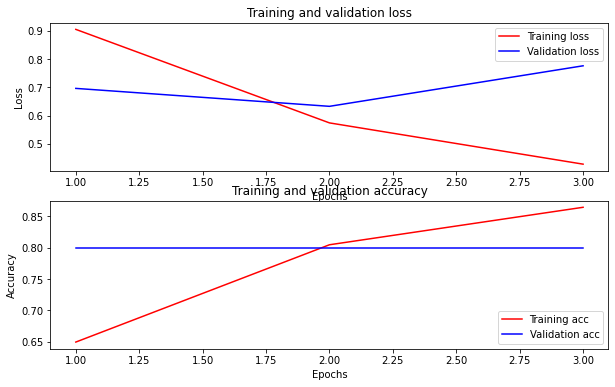

In [19]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc=history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [28]:
#Prediction

import numpy as np
predictions = classifier_model.predict(test_X)
print(len(test_X),len(test_y),len(predictions))
#print(predictions[:20])
result_array=[]

for x,y,pred in zip(test_X,test_y,predictions):
  result_array.append([x,np.argmax(y),np.argmax(pred)])                       


result_df=pd.DataFrame(result_array,columns=['OriginalTweet', 'Sentiment','PredictedSentiment'])
result_df.to_csv('./result.csv')

3798 3798 3798


In [ ]:
from sklearn.metrics import confusion_matrix
CLASSES = ['Extremely Negative', 'Negative', 'Positive', 'Extremely Positive', 'Neutral']
plt.title('confusion matrix - train data')
plt.xlabel("Predicted")
plt.ylabel("True")

preds = classifier_model.predict(train_X)

# Convert the one-hot vectors to labels
train_y_labels = tf.argmax(train_y, axis = 1)
preds_labels = tf.argmax(preds, axis = 1)

cm_train = tf.math.confusion_matrix(train_y_labels,
                                    preds_labels,5,
                                    dtype=tf.dtypes.float32)

# Normalize the confusion matrix so that each row sums to 1.
cm_train = cm_train/cm_train.numpy().sum(axis=1)[:, tf.newaxis]

sns.heatmap(data=cm_train,
            annot=True,
            xticklabels=CLASSES,
            yticklabels=CLASSES)

plt.show()